In [1]:
%run flow_tools.py

In [2]:
from matplotlib.path import Path
from matplotlib import patches

In [3]:
folders = ['../data/20220818 - ET Plate 1/',
          '../data/20220818 - ET Plate 2/',
          '../data/20220818 - ET Plate 3/']

In [4]:
df = [load_data(folder, colnames = ['WellName', 'Effector', 'Target', 'Ratio', 'Replicate', 'Plate']) for folder in folders]
df = pd.concat(df)

In [5]:
#remove all rows with values less than 0
df2= df.loc[(df.select_dtypes(include=['number']) > 0).all(axis='columns'), :]

#remove all rows with missing values
df2= df2.dropna()

In [6]:
event_counts = df2.groupby(['Plate', 'WellName'])['FSC-A'].count().reset_index()
event_counts['Row'] = event_counts['WellName'].apply(lambda x: x[0])
event_counts['Col'] = event_counts['WellName'].apply(lambda x: x[1:])
event_counts['PlateRow'] = event_counts['Plate'] + ' ' + event_counts['Row']

<AxesSubplot:xlabel='Col', ylabel='PlateRow'>

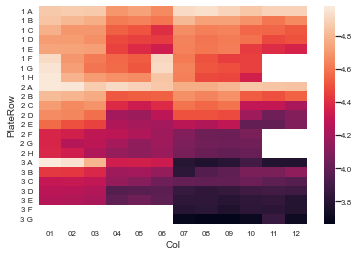

In [7]:
for_heatmap = event_counts.pivot_table(values='FSC-A', index='PlateRow', columns='Col')
sns.heatmap(np.log10(for_heatmap))

In [6]:
#define gate for FSC-A vs SSC-A
fsc_ssc_verts = [(4e4, 1e4),
              (1e5, 2.5e4),
              (2.75e5, 1e5),
              (2.75e5, 2.75e5),
              (1e5, 2.75e5),
              (4e4, 5e4),
              (4e4, 5e4),
              (4e4, 1e4)]
fsc_ssc_gate = Path(fsc_ssc_verts)

ssc_verts = [(0, 1e4),
              (2e5, 2e5),
              (2.7e5, 2e5),
              (2.7e5, 1.3e5),
              (1.25e5, 7.5e4),
              (1e4, 0),
              (0, 1e4)]
ssc_gate = Path(ssc_verts)

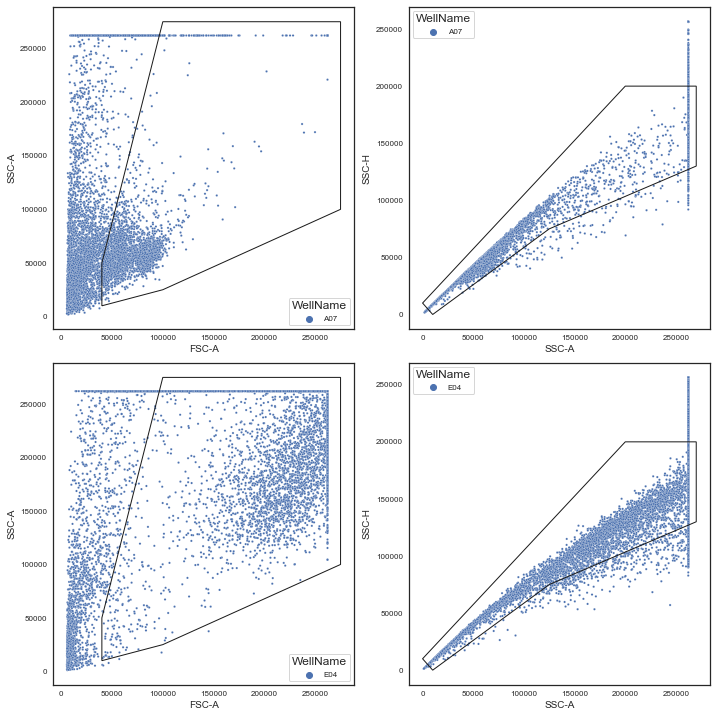

In [9]:
fig, axs = plt.subplots(2,2, figsize=[10,10])
sns.scatterplot(data=df2[(df2['WellName'].isin(['A07'])) & (df2['Plate']=='3')], x='FSC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[0,0], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['A07']) & (df2['Plate']=='3')], x='SSC-A', y='SSC-H', marker='o', s=5, edgecolors=None, ax=axs[0,1], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['E04']) & (df2['Plate']=='3')], x='FSC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[1,0], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['E04']) & (df2['Plate']=='3')], x='SSC-A', y='SSC-H', marker='o', s=5, edgecolors=None, ax=axs[1,1], hue='WellName')
patch = patches.PathPatch(fsc_ssc_gate, facecolor="None", edgecolor='k')
axs[0,0].add_patch(patch)
patch = patches.PathPatch(fsc_ssc_gate, facecolor="None", edgecolor='k')
axs[1,0].add_patch(patch)
patch = patches.PathPatch(ssc_gate, facecolor="None", edgecolor='k')
axs[0,1].add_patch(patch)
patch = patches.PathPatch(ssc_gate, facecolor="None", edgecolor='k')
axs[1,1].add_patch(patch)
plt.tight_layout()

In [7]:
#filter to gate
df2 = df2[fsc_ssc_gate.contains_points(df2[['FSC-A','SSC-A']].to_numpy())]
df2 = df2[ssc_gate.contains_points(df2[['SSC-A', 'SSC-H']].to_numpy())]
# # gate on singlets
# df2 = gate_density(df2, 0.1, x_var='SSC-A',y_var='SSC-H')

for col in df2.columns:
        if df2[col].dtype=="float32":
            df2["log"+ col]=df2[col].apply(math.log10)

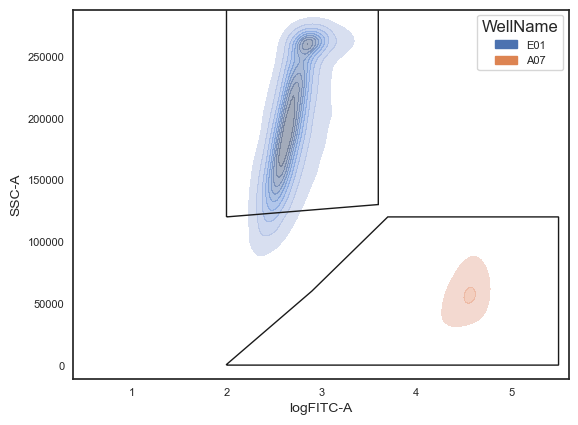

In [8]:
#define gate for FSC-A vs SSC-A
k562_verts = [(2, 1.2e5),
              (3.6, 1.3e5),
              (3.6, 2.9e5),
              (2, 2.9e5),
              (2, 2.5e5),
              (2, 1.2e5)]
k562_gate = Path(k562_verts)

tcell_verts = [(2, 1e2),
              (5.5, 1e2),
              (5.5, 1.2e5),
              (3.7, 1.2e5),
               (2.9, 6e4),
              (2, 6e2),
              (2, 1e2)]
tcell_gate = Path(tcell_verts)

parental_wells = df2[((df2['WellName'].isin(['A07'])) & (df2['Plate']=='3')) |
                     (df2['WellName'].isin(['E01']) & (df2['Plate']=='1'))]
fig, axs = plt.subplots(1,1)
sns.kdeplot(data=parental_wells, y='SSC-A', x='logFITC-A', fill=True, hue='WellName', alpha=0.5, ax=axs)
patch = patches.PathPatch(k562_gate, facecolor="None", edgecolor='k')
axs.add_patch(patch)
patch = patches.PathPatch(tcell_gate, facecolor="None", edgecolor='k')
axs.add_patch(patch)

In [9]:
target_filter = k562_gate.contains_points(df2[['logFITC-A','SSC-A']].to_numpy())
effector_filter = tcell_gate.contains_points(df2[['logFITC-A','SSC-A']].to_numpy())

df2['Type'] = 'Unknown'
df2.loc[target_filter, 'Type'] = 'Target'
df2.loc[effector_filter, 'Type'] = 'Effector'

In [10]:
effector_order = ['Untransduced','LCB1', 'LCB3', 'LCB1-Short','LCB1-Long','LCB1-Rigid','CD19']
target_order = ['CD19+', 'Spike+']
ratio_order = ['3:1', '1:1', '1:3', '1:9','1:27']

In [11]:
expression_df = (df2[(df2['Target']=='Surface')]
                 .groupby(['Effector','Replicate'])['logAPC-A']
                 .median()
                 .reset_index())
expression_df.to_csv('20220817_CAR_Expression.csv')